In [1]:
# 01_create_dataset.py
import pandas as pd
import numpy as np
import os

def create_synthetic_dataset(num_users=2000, fraud_percentage=0.05):
    """
    Generates a synthetic dataset of telecom user CDRs using MSISDNs.

    Args:
        num_users (int): The total number of unique users to simulate.
        fraud_percentage (float): The percentage of users who are fraudulent.

    Returns:
        pandas.DataFrame: A DataFrame containing the synthetic CDR data.
    """
    print("Step 1: Creating synthetic dataset with MSISDNs...")
    
    user_data = []
    # Generate realistic-looking MSISDNs (e.g., Singapore phone numbers)
    base_msisdn = 6590000000
    msisdns = [base_msisdn + i for i in range(num_users)]
    
    num_fraud_users = int(num_users * fraud_percentage)
    fraud_msisdns = np.random.choice(msisdns, size=num_fraud_users, replace=False)

    for msisdn in msisdns:
        is_fraud = msisdn in fraud_msisdns
        
        if is_fraud:
            # Simulate Fraudulent SIM Box Behavior
            num_records = np.random.randint(500, 2000)
            call_directions = np.random.choice(['outgoing', 'incoming'], size=num_records, p=[0.99, 0.01])
            call_durations = np.random.normal(loc=15, scale=5, size=num_records).clip(5, 60)
            hours = np.random.normal(loc=2, scale=3, size=num_records).astype(int) % 24
            imei = f"fraud_imei_{msisdn}"
            cell_tower = "tower_A"
        else:
            # Simulate Legitimate User Behavior
            num_records = np.random.randint(20, 300)
            call_directions = np.random.choice(['outgoing', 'incoming'], size=num_records, p=[0.6, 0.4])
            call_durations = np.random.exponential(scale=180, size=num_records).clip(10, 1800)
            hours = np.random.normal(loc=14, scale=5, size=num_records).astype(int) % 24
            imei = f"legit_imei_{msisdn}"
            cell_tower = np.random.choice(["tower_A", "tower_B", "tower_C", "tower_D"], p=[0.4, 0.3, 0.2, 0.1])

        for i in range(num_records):
            user_data.append({
                "msisdn": msisdn,
                "call_direction": call_directions[i],
                "duration": call_durations[i],
                "hour_of_day": hours[i],
                "imei": imei,
                "cell_tower": cell_tower,
                "is_fraud": is_fraud
            })
            
    print(f"Dataset created with {len(user_data)} records for {num_users} users.")
    return pd.DataFrame(user_data)

if __name__ == '__main__':
    output_filename = 'raw_cdr_data.csv'
    raw_df = create_synthetic_dataset(num_users=2000, fraud_percentage=0.05)
    raw_df.to_csv(output_filename, index=False)
    print(f"Raw synthetic dataset saved to '{output_filename}'")

Step 1: Creating synthetic dataset with MSISDNs...
Dataset created with 432385 records for 2000 users.
Raw synthetic dataset saved to 'raw_cdr_data.csv'


In [2]:
# 02_train_model_rfc.py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

def feature_engineering(df):
    """
    Processes the raw CDR data to create aggregated features for each user.
    """
    print("Performing feature engineering...")
    user_features = df.groupby('msisdn').agg(
        total_calls=('msisdn', 'count'),
        outgoing_call_ratio=('call_direction', lambda x: (x == 'outgoing').sum() / len(x)),
        avg_duration=('duration', 'mean'),
        std_duration=('duration', 'std'),
        nocturnal_call_ratio=('hour_of_day', lambda h: (h.between(22, 24).sum() + h.between(0, 6).sum()) / len(h)),
        mobility=('cell_tower', 'nunique'),
        is_fraud=('is_fraud', 'first')
    ).reset_index()
    user_features.fillna(0, inplace=True)
    return user_features

def train_fraud_detection_model_rfc(features_df):
    """
    Trains a Random Forest model and saves it to a file.
    """
    print("\nTraining the Random Forest model...")
    
    X = features_df.drop(['msisdn', 'is_fraud'], axis=1)
    y = features_df['is_fraud']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', oob_score=True)
    model.fit(X_train, y_train)
    
    print("Model Evaluation on Test Set:")
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances)
    
    return model

if __name__ == '__main__':
    raw_data_filename = 'raw_cdr_data.csv'
    model_output_filename = 'fraud_detection_model_rfc.joblib'
    
    try:
        raw_df = pd.read_csv(raw_data_filename)
    except FileNotFoundError:
        print(f"Error: Raw data file not found at '{raw_data_filename}'.")
        print("Please run '01_create_dataset.py' first.")
        exit()

    features_df = feature_engineering(raw_df)
    fraud_model = train_fraud_detection_model_rfc(features_df)
    joblib.dump(fraud_model, model_output_filename)
    
    print(f"\nTrained Random Forest model saved to '{model_output_filename}'")


Performing feature engineering...

Training the Random Forest model...
Model Evaluation on Test Set:
[[380   0]
 [  0  20]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       380
        True       1.00      1.00      1.00        20

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Feature Importances:
total_calls             0.23
outgoing_call_ratio     0.23
std_duration            0.19
nocturnal_call_ratio    0.18
avg_duration            0.17
mobility                0.00
dtype: float64

Trained Random Forest model saved to 'fraud_detection_model_rfc.joblib'


In [3]:
# 03_create_inference_data.py
import pandas as pd
import numpy as np

def create_synthetic_dataset_for_inference(num_users=500, fraud_percentage=0.06):
    """
    Generates a new synthetic dataset of raw CDRs specifically for inference.
    """
    print(f"Generating a new dataset with {num_users} users for inference...")
    user_data = []
    # Use a different range for MSISDNs to ensure they are "new"
    base_msisdn = 6580000000
    msisdns = [base_msisdn + i for i in range(num_users)]
    
    num_fraud_users = int(num_users * fraud_percentage)
    fraud_msisdns = np.random.choice(msisdns, size=num_fraud_users, replace=False)

    for msisdn in msisdns:
        is_fraud = msisdn in fraud_msisdns
        if is_fraud:
            num_records, p_out, dur_loc, dur_scale, hr_loc = (np.random.randint(500, 2000), [0.99, 0.01], 15, 5, 2)
            cell_tower = "tower_A"
        else:
            num_records, p_out, dur_loc, dur_scale, hr_loc = (np.random.randint(20, 300), [0.6, 0.4], 180, 180, 14)
            cell_tower = np.random.choice(["tower_A", "tower_B", "tower_C", "tower_D"], p=[0.4, 0.3, 0.2, 0.1])
        call_directions = np.random.choice(['outgoing', 'incoming'], size=num_records, p=p_out)
        call_durations = np.random.normal(loc=dur_loc, scale=dur_scale, size=num_records).clip(5, 1800)
        hours = np.random.normal(loc=hr_loc, scale=5, size=num_records).astype(int) % 24
        for i in range(num_records):
            user_data.append({"msisdn": msisdn, "call_direction": call_directions[i], "duration": call_durations[i], "hour_of_day": hours[i], "cell_tower": cell_tower, "is_fraud": is_fraud})
            
    print(f"Inference dataset created with {len(user_data)} records.")
    return pd.DataFrame(user_data)

if __name__ == '__main__':
    inference_data_filename = 'inference_raw_cdr_data.csv'
    new_raw_data = create_synthetic_dataset_for_inference(num_users=500)
    new_raw_data.to_csv(inference_data_filename, index=False)
    print(f"New raw data for inference saved to '{inference_data_filename}'")


Generating a new dataset with 500 users for inference...
Inference dataset created with 105173 records.
New raw data for inference saved to 'inference_raw_cdr_data.csv'


In [4]:
# 04_infer_model_rfc.py
import pandas as pd
import joblib

def feature_engineering(df):
    """
    Processes the raw CDR data to create aggregated features for each user.
    """
    print("Performing feature engineering on new data...")
    user_features = df.groupby('msisdn').agg(
        total_calls=('msisdn', 'count'),
        outgoing_call_ratio=('call_direction', lambda x: (x == 'outgoing').sum() / len(x)),
        avg_duration=('duration', 'mean'),
        std_duration=('duration', 'std'),
        nocturnal_call_ratio=('hour_of_day', lambda h: (h.between(22, 24).sum() + h.between(0, 6).sum()) / len(h)),
        mobility=('cell_tower', 'nunique'),
        is_fraud=('is_fraud', 'first')
    ).reset_index()
    user_features.fillna(0, inplace=True)
    return user_features

def run_inference(model, new_data_df):
    """
    Runs inference on the new dataset and returns predictions.
    """
    print("Running inference with Random Forest model...")
    
    new_features_df = feature_engineering(new_data_df)
    
    X_new = new_features_df.drop(['msisdn', 'is_fraud'], axis=1)
    
    predictions = model.predict(X_new)
    prediction_proba = model.predict_proba(X_new)[:, 1]
    
    new_features_df['predicted_fraud'] = predictions
    new_features_df['fraud_probability'] = prediction_proba
    
    print("\nInference complete. Fraudulent users identified:")
    print(new_features_df[new_features_df['predicted_fraud'] == True][['msisdn', 'is_fraud', 'fraud_probability']])
    
    return new_features_df

if __name__ == '__main__':
    model_filename = 'fraud_detection_model_rfc.joblib'
    inference_data_filename = 'inference_raw_cdr_data.csv'
    inference_output_filename = 'inference_results_rfc.csv'

    try:
        model = joblib.load(model_filename)
    except FileNotFoundError:
        print(f"Error: Model file not found at '{model_filename}'.")
        print("Please run '02_train_model_rfc.py' first.")
        exit()
        
    try:
        new_raw_data = pd.read_csv(inference_data_filename)
    except FileNotFoundError:
        print(f"Error: Inference data file not found at '{inference_data_filename}'.")
        print("Please run '03_create_inference_data.py' first.")
        exit()
        
    inferred_results = run_inference(model, new_raw_data)
    
    total_inferred_users = len(inferred_results)
    fraudulent_count = int(inferred_results['predicted_fraud'].sum())
    print("\n--- Inference Summary ---")
    print(f"Total MSISDNs in inference dataset: {total_inferred_users}")
    print(f"Number of MSISDNs predicted as fraudulent: {fraudulent_count}")
    print("-------------------------")
    
    inferred_results.to_csv(inference_output_filename, index=False)
    print(f"\nInference results saved to '{inference_output_filename}'")


Running inference with Random Forest model...
Performing feature engineering on new data...

Inference complete. Fraudulent users identified:
         msisdn  is_fraud  fraud_probability
19   6580000019      True                1.0
24   6580000024      True                1.0
59   6580000059      True                1.0
60   6580000060      True                1.0
70   6580000070      True                1.0
82   6580000082      True                1.0
114  6580000114      True                1.0
142  6580000142      True                1.0
162  6580000162      True                1.0
163  6580000163      True                1.0
189  6580000189      True                1.0
198  6580000198      True                1.0
216  6580000216      True                1.0
217  6580000217      True                1.0
247  6580000247      True                1.0
280  6580000280      True                1.0
288  6580000288      True                1.0
304  6580000304      True                1.0
314

Visualizing the frauds from inference results in 2D...
2D Visualization saved to 'fraud_frauds_visualization_2d.png'


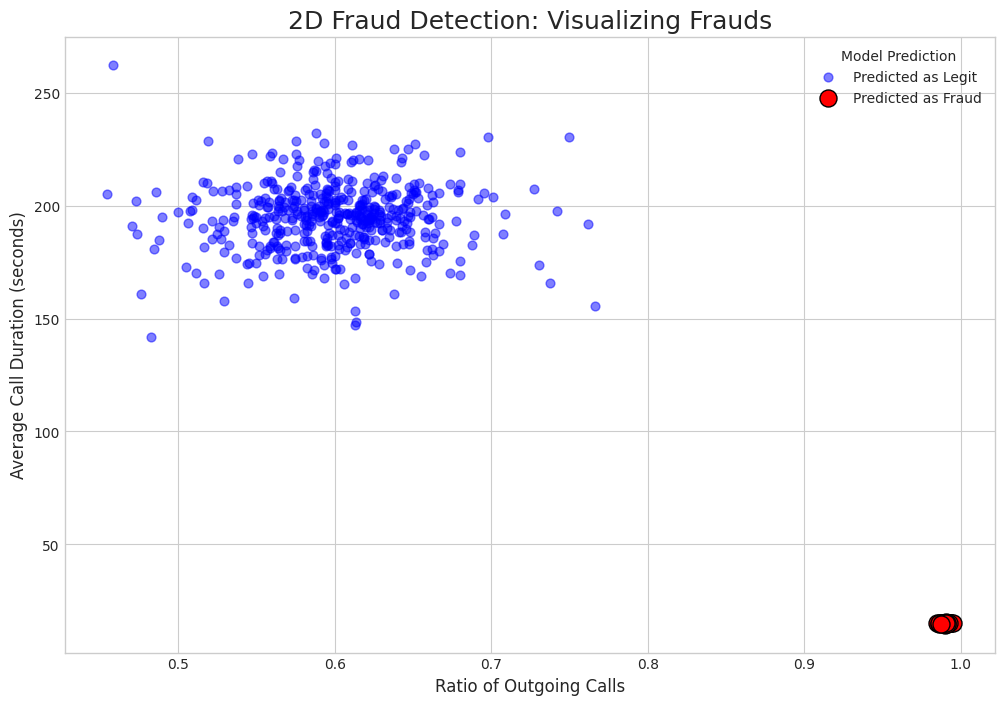

In [5]:
# 05_visualize_results.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_frauds_2d(inferred_df):
    """
    Creates a 2D scatter plot to visualize the separation of fraudulent and legitimate users.
    """
    print("Visualizing the frauds from inference results in 2D...")
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))
    
    predicted_legit = inferred_df[inferred_df['predicted_fraud'] == False]
    predicted_fraud = inferred_df[inferred_df['predicted_fraud'] == True]

    if not predicted_legit.empty:
        ax.scatter(predicted_legit['outgoing_call_ratio'], predicted_legit['avg_duration'],
                   c='blue', marker='o', s=40, alpha=0.5, label='Predicted as Legit')
    
    if not predicted_fraud.empty:
        ax.scatter(predicted_fraud['outgoing_call_ratio'], predicted_fraud['avg_duration'],
                   c='red', marker='o', s=150, label='Predicted as Fraud', edgecolor='k')

    ax.set_title('2D Fraud Detection: Visualizing Frauds', fontsize=18)
    ax.set_xlabel('Ratio of Outgoing Calls', fontsize=12)
    ax.set_ylabel('Average Call Duration (seconds)', fontsize=12)
    ax.legend(title='Model Prediction', fontsize=10)
        
    plot_filename = 'fraud_frauds_visualization_2d.png'
    plt.savefig(plot_filename, dpi=300)
    print(f"2D Visualization saved to '{plot_filename}'")
    plt.show()

if __name__ == '__main__':
    results_filename = 'inference_results_rfc.csv'
    
    try:
        inferred_df = pd.read_csv(results_filename)
    except FileNotFoundError:
        print(f"Error: Inference results file not found at '{results_filename}'.")
        print("Please run '04_infer_model_rfc.py' first.")
        exit()
        
    visualize_frauds_2d(inferred_df)


In [6]:
# 02_train_model_xgb.py
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

def feature_engineering(df):
    """
    Processes the raw CDR data to create aggregated features for each user.
    """
    print("Performing feature engineering...")
    user_features = df.groupby('msisdn').agg(
        total_calls=('msisdn', 'count'),
        outgoing_call_ratio=('call_direction', lambda x: (x == 'outgoing').sum() / len(x)),
        avg_duration=('duration', 'mean'),
        std_duration=('duration', 'std'),
        nocturnal_call_ratio=('hour_of_day', lambda h: (h.between(22, 24).sum() + h.between(0, 6).sum()) / len(h)),
        mobility=('cell_tower', 'nunique'),
        is_fraud=('is_fraud', 'first')
    ).reset_index()
    user_features.fillna(0, inplace=True)
    return user_features

def train_fraud_detection_model_xgb(features_df):
    """
    Trains an XGBoost model and saves it to a file.
    """
    print("\nTraining the XGBoost model...")
    
    X = features_df.drop(['msisdn', 'is_fraud'], axis=1)
    y = features_df['is_fraud']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Calculate scale_pos_weight for handling class imbalance
    # FIXED: Using boolean labels .loc[False] and .loc[True] to access the counts
    scale_pos_weight = y_train.value_counts().loc[False] / y_train.value_counts().loc[True]
    
    # Initialize and train the XGBoost classifier
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    print("Model Evaluation on Test Set:")
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances)
    
    return model

if __name__ == '__main__':
    raw_data_filename = 'raw_cdr_data.csv'
    model_output_filename = 'fraud_detection_model_xgb.joblib'
    
    try:
        raw_df = pd.read_csv(raw_data_filename)
    except FileNotFoundError:
        print(f"Error: Raw data file not found at '{raw_data_filename}'.")
        print("Please run '01_create_dataset.py' first.")
        exit()

    features_df = feature_engineering(raw_df)
    fraud_model = train_fraud_detection_model_xgb(features_df)
    joblib.dump(fraud_model, model_output_filename)
    
    print(f"\nTrained XGBoost model saved to '{model_output_filename}'")


Performing feature engineering...

Training the XGBoost model...
Model Evaluation on Test Set:
[[380   0]
 [  0  20]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       380
        True       1.00      1.00      1.00        20

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Feature Importances:
avg_duration            0.514736
std_duration            0.232871
nocturnal_call_ratio    0.114148
outgoing_call_ratio     0.109177
total_calls             0.029068
mobility                0.000000
dtype: float32

Trained XGBoost model saved to 'fraud_detection_model_xgb.joblib'


In [7]:
# 04_infer_model_xgb.py
import pandas as pd
import joblib

def feature_engineering(df):
    """
    Processes the raw CDR data to create aggregated features for each user.
    """
    print("Performing feature engineering on new data...")
    user_features = df.groupby('msisdn').agg(
        total_calls=('msisdn', 'count'),
        outgoing_call_ratio=('call_direction', lambda x: (x == 'outgoing').sum() / len(x)),
        avg_duration=('duration', 'mean'),
        std_duration=('duration', 'std'),
        nocturnal_call_ratio=('hour_of_day', lambda h: (h.between(22, 24).sum() + h.between(0, 6).sum()) / len(h)),
        mobility=('cell_tower', 'nunique'),
        is_fraud=('is_fraud', 'first')
    ).reset_index()
    user_features.fillna(0, inplace=True)
    return user_features

def run_inference(model, new_data_df):
    """
    Runs inference on the new dataset and returns predictions.
    """
    print("Running inference with XGBoost model...")
    
    new_features_df = feature_engineering(new_data_df)
    
    X_new = new_features_df.drop(['msisdn', 'is_fraud'], axis=1)
    
    predictions = model.predict(X_new)
    prediction_proba = model.predict_proba(X_new)[:, 1]
    
    new_features_df['predicted_fraud'] = predictions
    new_features_df['fraud_probability'] = prediction_proba
    
    print("\nInference complete. Fraudulent users identified:")
    print(new_features_df[new_features_df['predicted_fraud'] == True][['msisdn', 'is_fraud', 'fraud_probability']])
    
    return new_features_df

if __name__ == '__main__':
    model_filename = 'fraud_detection_model_xgb.joblib'
    inference_data_filename = 'inference_raw_cdr_data.csv'
    inference_output_filename = 'inference_results_xgb.csv'

    try:
        model = joblib.load(model_filename)
    except FileNotFoundError:
        print(f"Error: Model file not found at '{model_filename}'.")
        print("Please run the new '02_train_model_xgb.py' script first.")
        exit()
        
    try:
        new_raw_data = pd.read_csv(inference_data_filename)
    except FileNotFoundError:
        print(f"Error: Inference data file not found at '{inference_data_filename}'.")
        print("Please run '03_create_inference_data.py' first.")
        exit()
        
    inferred_results = run_inference(model, new_raw_data)
    
    total_inferred_users = len(inferred_results)
    fraudulent_count = int(inferred_results['predicted_fraud'].sum())
    print("\n--- Inference Summary ---")
    print(f"Total MSISDNs in inference dataset: {total_inferred_users}")
    print(f"Number of MSISDNs predicted as fraudulent: {fraudulent_count}")
    print("-------------------------")
    
    inferred_results.to_csv(inference_output_filename, index=False)
    print(f"\nInference results saved to '{inference_output_filename}'")


Running inference with XGBoost model...
Performing feature engineering on new data...

Inference complete. Fraudulent users identified:
         msisdn  is_fraud  fraud_probability
19   6580000019      True           0.999388
24   6580000024      True           0.999156
59   6580000059      True           0.999156
60   6580000060      True           0.999388
70   6580000070      True           0.999388
82   6580000082      True           0.999388
114  6580000114      True           0.999388
142  6580000142      True           0.999388
162  6580000162      True           0.999388
163  6580000163      True           0.999388
189  6580000189      True           0.999388
198  6580000198      True           0.999388
216  6580000216      True           0.999388
217  6580000217      True           0.999388
247  6580000247      True           0.999388
280  6580000280      True           0.999388
288  6580000288      True           0.999388
304  6580000304      True           0.999388
314  6580